In [ ]:
!pip install roboflow
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-man

In [1]:
from PIL import Image
import cv2
import tensorflow as tf


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import time
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torchvision.models.detection import SSDLite320_MobileNet_V3_Large_Weights
import json
import torchvision
from torch.utils.data import DataLoader, TensorDataset, Dataset



from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/gdrive')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mounted at /content/gdrive


In [2]:
ssd_times = pd.read_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/inference_times.csv')
yolo_times = pd.read_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/YOLO_Model_inference_times.csv')
trad_times = pd.read_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/Traditional_inference_times.csv')

inf_times = pd.concat([ssd_times, yolo_times,trad_times], axis=1)

In [3]:
inf_times['SSD_Model'] = inf_times['SSD_Model'] * 1000
inf_times['Traditional_Model'] = inf_times['Traditional_Model'] * 1000
inf_times

,SSD_Model,YOLO_Model,Traditional_Model
0,136.627436,22.566319,20.380020
1,15.349627,22.489786,9.388447
2,14.380932,19.712925,10.039568
3,16.198635,19.933462,20.151854
4,14.746428,32.090664,9.938240
...,...,...,...
59,13.248682,14.419317,15.267611
60,14.928341,13.991117,15.521049
61,13.387203,13.557673,18.635988
62,13.315678,13.558626,12.250662


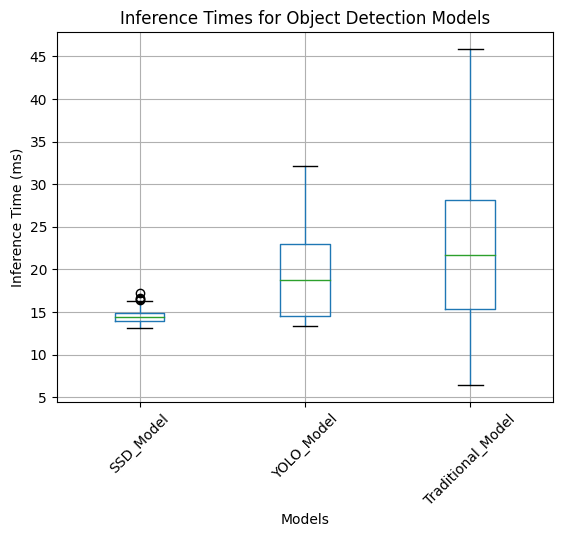

In [10]:
# Plot the boxplot without outliers
def remove_outliers_iqr(df, columns):
    """
    Remove outliers from specified columns of a DataFrame using the IQR method.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    columns (list): The list of column names to remove outliers from.

    Returns:
    pd.DataFrame: The DataFrame with outliers removed.
    """
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

columns = ['SSD_Model', 'YOLO_Model', 'Traditional_Model']
df_clean = remove_outliers_iqr(inf_times, columns)

df_clean.boxplot(column=columns)
plt.title('Inference Times for Object Detection Models')
plt.xlabel('Models')
plt.ylabel('Inference Time (ms)')
plt.xticks(rotation=45)
plt.show()

In [5]:
ssd_spread = pd.read_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/SSD_Model_Data_Spread.csv')
yolo_spread = pd.read_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/YOLO_Model_Data_Spread.csv')
trad_spread = pd.read_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/Traditional_Model_Data_Spread.csv')

data_spread = pd.concat([ssd_spread, yolo_spread,trad_spread], axis=0)
data_spread['Models']= ['SSD', 'YOLO', 'Traditional']


In [6]:
ssd_curves_car = pd.read_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/SSD_Model_Car_Class_APRF.csv')
ssd_curves_plate = pd.read_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/SSD_Model_Plate_Class_APRF.csv')

yolo_curves_car = pd.read_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/YOLO_Model_Car_Class_APRF.csv')
yolo_curves_plate = pd.read_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/YOLO_Model_Plate_Class_APRF.csv')

trad_curves = pd.read_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/Traditional_Model_Plate_Class_APRF.csv')

In [7]:
trad_curves

,Image,TP,FP,FN,TP_acc,FP_acc,FN_acc,Precision,Recall,F1
0,Image 29,1,0,0,1,0,0,1.000000,0.012821,0.000000
1,Image 47,1,0,0,2,0,0,1.000000,0.025000,0.048780
2,Image 24,1,0,0,3,0,0,1.000000,0.037037,0.071429
3,Image 24,1,0,0,4,0,0,1.000000,0.048780,0.093023
4,Image 48,1,0,0,5,0,0,1.000000,0.060241,0.113636
...,...,...,...,...,...,...,...,...,...,...
124,Image 30,0,1,0,24,68,33,0.260870,0.235294,0.247423
125,Image 29,0,1,0,24,69,33,0.258065,0.235294,0.246154
126,Image 29,0,1,0,24,70,33,0.255319,0.235294,0.244898
127,Image 29,0,1,0,24,71,33,0.252632,0.235294,0.243655


In [8]:
data = {
    'Predicted Cars': [ssd_curves_car.iloc[-1]['TP_acc'],yolo_curves_car.iloc[-1]['TP_acc'], float('nan')],
    'Actual Cars': data_spread['Actual Cars'],
    'Predicted Plates': [ssd_curves_plate.iloc[-1]['TP_acc'],yolo_curves_plate.iloc[-1]['TP_acc'], trad_curves.iloc[-1]['TP_acc']],
    'Actual Plates': data_spread['Actual Plates'],
    'Models':['SSD', 'YOLO', 'Traditional']
}

df = pd.DataFrame(data)
df


,Predicted Cars,Actual Cars,Predicted Plates,Actual Plates,Models
0,279.0,125.0,46,78,SSD
0,104.0,125.0,66,78,YOLO
0,NaN,NaN,24,78,Traditional


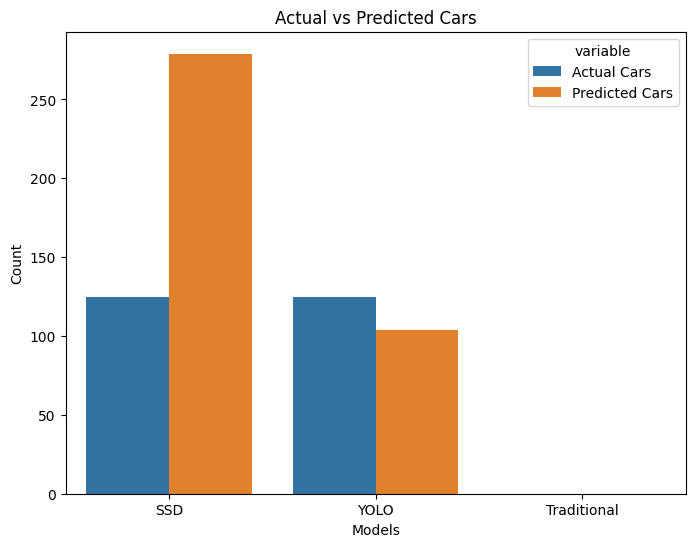

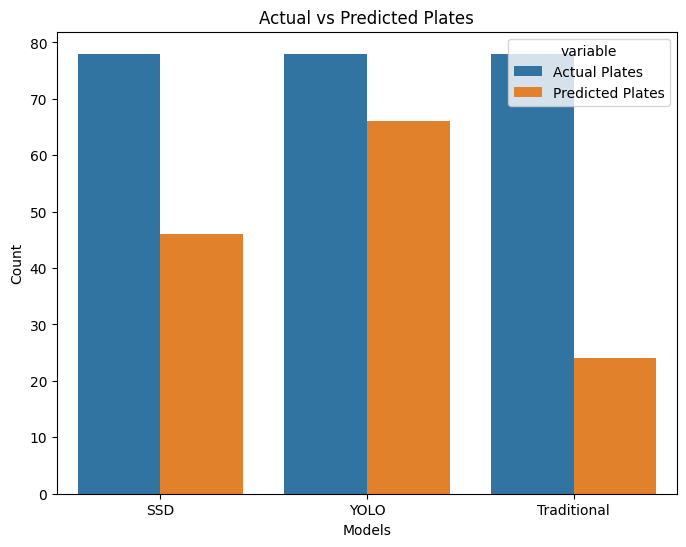

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size for better visibility
# Plot actual and predicted cars
plt.figure(figsize=(8, 6))
sns.barplot(x='Models', y='value', hue='variable', data=pd.melt(df, id_vars=['Models'], value_vars=['Actual Cars', 'Predicted Cars']))
plt.title('Actual vs Predicted Cars')
plt.ylabel('Count')
plt.xlabel('Models')
plt.show()

# Plot actual and predicted plates
plt.figure(figsize=(8, 6))
sns.barplot(x='Models', y='value', hue='variable', data=pd.melt(df, id_vars=['Models'], value_vars=['Actual Plates', 'Predicted Plates']))
plt.title('Actual vs Predicted Plates')
plt.ylabel('Count')
plt.xlabel('Models')
plt.show()

#PR Curves

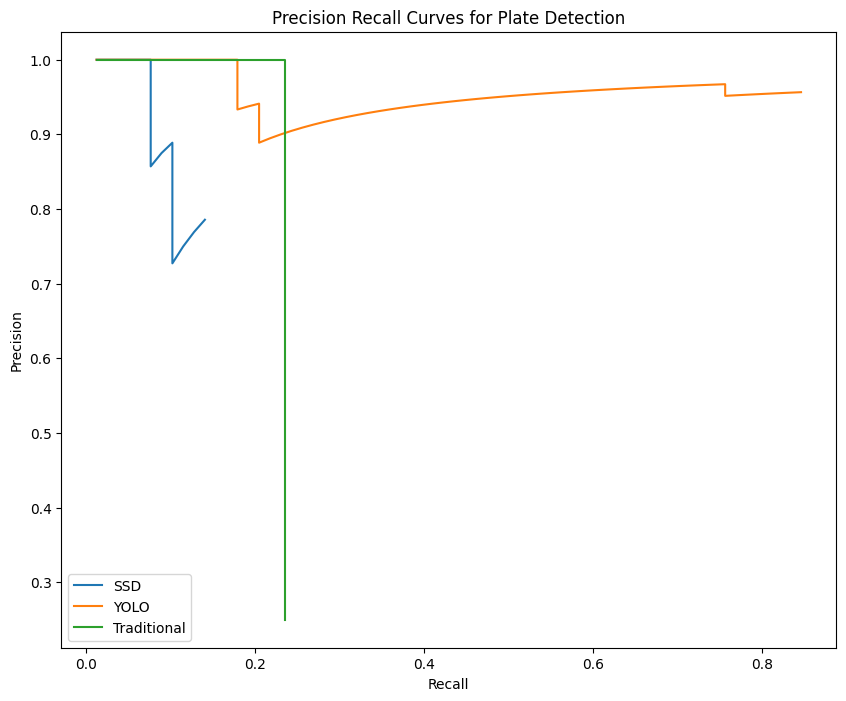

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(ssd_curves_plate['Recall'], ssd_curves_plate['Precision'])
plt.plot(yolo_curves_plate['Recall'], yolo_curves_plate['Precision'])
plt.plot(trad_curves['Recall'], trad_curves['Precision'])

plt.legend(['SSD', 'YOLO','Traditional'])
plt.title('Precision Recall Curves for Plate Detection')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.show()

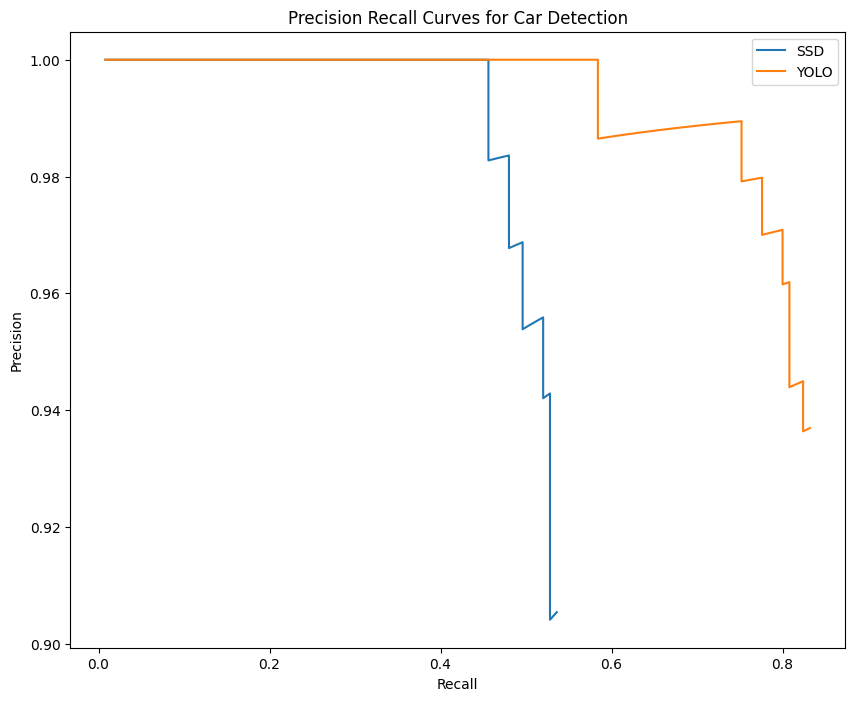

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(ssd_curves_car['Recall'], ssd_curves_car['Precision'])
plt.plot(yolo_curves_car['Recall'], yolo_curves_car['Precision'])
# plt.plot(trad_curves['Recall'], trad_curves['Precision'])

plt.legend(['SSD', 'YOLO'])
plt.title('Precision Recall Curves for Car Detection')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.show()

In [ ]:
weights = SSDLite320_MobileNet_V3_Large_Weights.DEFAULT
num_classes = 3
ssd_model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(num_classes=num_classes)
preprocess = weights.transforms()

ssd_model.load_state_dict(torch.load('/content/gdrive/My Drive/MSc Project/Saved Models/ssd.pth', map_location=torch.device('cpu')))
ssd_model.eval()
from ultralytics import YOLO
drive_path = '/content/gdrive/My Drive/MSc Project/Saved Models/yolov8n.pt'
yolo_model = YOLO(drive_path)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 118MB/s] 


In [ ]:
from roboflow import Roboflow
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rf = Roboflow(api_key="IYwf0SjALphOAs60cx0U")
project = rf.workspace("myworkspace-zkmzj").project("license-plate-detector-no-brand")
version = project.version(1)
dataset = version.download("coco")

# # Define paths to your dataset folders
test_folder = "License-Plate-Detector---no-brand-1/test/"

# # Get list of all image files in the images folder
def extract_file_paths(dir):
  json_file = ''
  for f in os.listdir(dir):
    if f.endswith('.json'):
      json_file = dir+f
  return json_file

def extract_image_paths(dir):
  image_files = []
  for f in os.listdir(dir):
    if f.endswith('.jpg'):
      image_files.append(dir+f)

  return image_files

# Opens annotation file
def extract_annotations(label_file):
  f= open(label_file)
  anns =json.load(f)
  return anns
def create_dfs(dir, anns):
  img_df = pd.DataFrame(anns['images'])
  img_df.drop(['height', 'width', 'date_captured', 'license'],axis=1, inplace=True)
  img_df['file_name'] = dir+img_df['file_name']

  ann_df = pd.DataFrame(anns['annotations'])
  ann_df.drop(['segmentation', 'iscrowd', 'area'], axis=1, inplace=True)
  # Extracting bbox values and creating new columns
  ann_df[['x1', 'y1', 'w', 'h']] = pd.DataFrame(ann_df['bbox'].tolist(), index=ann_df.index)
  ann_df['x2'] = ann_df['x1'] + ann_df['w']
  ann_df['y2'] = ann_df['y1'] + ann_df['h']

  ann_df.drop(['w', 'h', 'bbox'], axis=1, inplace=True)

  return img_df, ann_df
class CustomDataset(Dataset):
    def __init__(self, image_df, annotations_df, transforms=None):
        self.image_df = image_df
        self.annotations_df = annotations_df
        self.transforms = transforms

    def __len__(self):
        return len(self.image_df)

    def __getitem__(self, idx):
        # Get image path and load image
        image_id = self.image_df.iloc[idx]['id']
        img_path = self.image_df.iloc[idx]['file_name']
        image = Image.open(img_path).convert("RGB")

        # Get annotations for the image
        annots = self.annotations_df[self.annotations_df['image_id'] == image_id]
        boxes = annots[['x1', 'y1', 'x2', 'y2']].values
        labels = annots['category_id'].values

        # Convert to PyTorch tensors


        if self.transforms is not None:
          image = self.transforms(image)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        return image, target

def collate_function(data):
  return data


test_label_file = extract_file_paths(test_folder)
test_image_files = extract_image_paths(test_folder)
test_anns = extract_annotations(test_label_file)
test_img_df, test_ann_df = create_dfs(test_folder,test_anns)
test_set = CustomDataset(test_img_df, test_ann_df,preprocess)
test_loader = DataLoader(test_set,
                        batch_size=test_set.__len__(),
                        shuffle = True,
                        drop_last=True,
                        collate_fn=collate_function)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to License-Plate-Detector---no-brand-1 in coco:: 100%|██████████| 2126/2126 [00:00<00:00, 2997.09it/s]


In [ ]:
def plot_image_from_df(file_path):
  img = Image.open(file_path)
  fig, ax = plt.subplots()
  ax.imshow(img)
  plt.show()

In [ ]:
import torchvision.transforms as T
from PIL import Image, ImageDraw

def load_image(img_path):
    img = Image.open(img_path)
    img = T.ToTensor()(img).unsqueeze(0)
    return img





In [ ]:
from torchvision.ops import nms
import matplotlib.patches as patches

def reduce_prediction(boxes, scores,classes):
  conf_threshold = 0.5
  mask = scores >= conf_threshold
  boxes, scores, classes = boxes[mask], scores[mask], classes[mask]
  keeps = torchvision.ops.nms(boxes, scores, 0.5)

  # nms_boxes = nms(boxes, scores, 0.1) #returns a list of indexes of the good predictions
  return boxes[keeps].cpu(), scores[keeps].cpu(), classes[keeps].cpu()
def plot_detections(img, detections):
    class_colors = {
    '0':'red',
    '1':'blue'
    }
    img = T.ToPILImage()(img.squeeze(0))
    draw = ImageDraw.Draw(img)
    # Extract bounding boxes from detections
    boxes = detections[0].boxes.xyxy.cpu().numpy()
    # Iterate through the boxes
    cropped_img = None
    for i, box in enumerate(boxes):
      x1, y1, x2, y2 = box[:4]  # Extract coordinates
      conf = detections[0].boxes.conf[i].item()  # Extract confidence score
      label = int(detections[0].boxes.cls[i].item()) # Extract label (if available)
      # if label == 1:
      #   cropped_img = img.crop((x1-5,y1-5, x2+5,y2+5))
      #   cropped_img = np.array(cropped_img)
      # Draw bounding box
      draw.rectangle([x1, y1, x2, y2], outline=class_colors[str(label)], width=3)
      # print(x1,y1,x2,y2)
      # draw.text((x1, y1-15), f'{label}, {conf:.2f}', fill='red')

    return img
def plot_ssd_predictions(image, boxes, scores, classes, score_threshold=0.4):
    class_colors = {
    '1':'red',
    '2':'blue'
    }
    refined_boxes = nms(boxes, scores, 0.4)
    picked_boxes = boxes[refined_boxes]
    img = T.ToPILImage()(image.squeeze(0))
    draw = ImageDraw.Draw(img)

    # Plot each bounding box
    for box, score, cls in zip(picked_boxes, scores, classes):
        if score >= score_threshold:
            x1, y1, x2, y2 = box
            draw.rectangle([x1, y1, x2, y2], outline=class_colors[str(cls.item())], width=3)
    return img


def plot_imgs(yolo, ssd, trad):
  fig, ax = plt.subplots(1,3,figsize=(10,20))
  ax[0].imshow(yolo)
  ax[0].set_title('Yolo Detections')
  ax[0].axis('off')

  ax[1].imshow(ssd)
  ax[1].set_title('SSD Detections')
  ax[1].axis('off')

  ax[2].imshow(trad)
  ax[2].set_title('Canny Detections')
  ax[2].axis('off')

  plt.show()

In [ ]:
def is_license_plate_contour(contour):
    # Calculate the bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)
    # Calculate the area of the bounding box
    bounding_area = w*h
    contour_area = cv2.contourArea(contour)
    #  rectangulatiry check
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    # if len(approx) > 4:
    #   return False
    if not cv2.isContourConvex(approx):
      return False
    # Calculate aspect ratio
    # aspect_ratio = float(w) / h
    # if aspect_ratio < 2 or aspect_ratio > 6:
    #     return False
    if contour_area < 1000 or contour_area > 6000:  # Adjust these thresholds based on the size of the image and expected license plate size
        return False
    if contour[0][0][1] < 200: #
      return False
    # Limit Height
    if h < 30:
      return False
    # Check for rectangularity
    # if contour_area < 0.6 * bounding_area:  # The contour area should be at least 80% of the bounding box area
    #     return False

    return True

def normalize_image(img):
  # Normalize image
  normalized_image = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
  return normalized_image

def get_canny_edges(img, thresh1=100, thresh2=200):
    # img_blur = cv2.GaussianBlur(img, (3, 3), 0)
    # img_blur =cv2.bilateralFilter(img, 11,17,17)
    canny_edged = cv2.Canny(img, 100, 200)
    return canny_edged

def find_contours(edges):
    if len(edges.shape) == 3:
        edges = cv2.cvtColor(edges, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(edges, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    # return contours
    contour_areas = [(cv2.contourArea(cnt), cnt) for cnt in contours]
    contour_areas.sort(key=lambda x: x[0], reverse=True)

# Get the top 10 largest contours
    top_10_contours = [cnt for _, cnt in contour_areas[:10]]
    # for cnt in top_10_contours:
      # print(cv2.contourArea(cnt))
    return top_10_contours

def licenesPlatePipeline(img):
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  eq_img = cv2.equalizeHist(gray_img)
  blurred = cv2.GaussianBlur(eq_img,(3,3), 0)
  threshed = cv2.threshold(blurred, 0,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
  edged = get_canny_edges(threshed, 50, 60)
  # cv2_imshow(edged)

  contours = find_contours(edged)
  accepted_contours = [c for c in contours if is_license_plate_contour(c)]
  bboxes = []
  for c in accepted_contours:
    x,y,w,h = cv2.boundingRect(c)
    bboxes.append(torch.tensor([x,y,x+w,y+h]))
  img_copy = img.copy()
  for bbox in bboxes:
        x1, y1, x2, y2 = bbox.numpy()
        cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Blue bounding boxes with a thickness of 2

  # cv2.drawContours(img_copy,contours, -1, (0,0,255),2)
  return img_copy

In [ ]:
def test_inference(model):
  model.to(device)
  model.eval()
  with torch.no_grad():
    for data in test_loader:
      imgs = []
      for d in data:
        imgs.append(d[0].to(device))
      test_dict = model(imgs)
      break
  return test_dict, imgs

  import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from torchvision.ops import nms

def plot_predictions(image, boxes, scores, classes, class_names, score_threshold=0.4):
    # Create a figure and axis
    fig, ax = plt.subplots(1)
    ax.imshow(image.permute(1,2,0).cpu())
    refined_boxes = nms(boxes, scores, 0.4)
    picked_boxes = boxes[refined_boxes]

    # Plot each bounding box
    for box, score, cls in zip(picked_boxes, scores, classes):
        if score >= score_threshold:
            x1, y1, x2, y2 = box
            # Create a rectangle patch
            rect = patches.Rectangle(
                (x1.item(), y1.item()), x2.item()-x1.item(), y2.item()-y1.item(), linewidth=2, edgecolor='r', facecolor='none'
            )
            print
            # Add the patch to the Axes
            ax.add_patch(rect)

            # Label with class name and score
            class_name = class_names[str(cls.item())]
            label = f'{class_name}: {score:.2f}'
            ax.text(x1, y1 - 10, label, color='white', fontsize=10, backgroundcolor='red')

            # Or label with the class number and the score
            # label = f'{str(cls.item())}:{score:.2f}'
            # ax.text(x1, y1 - 10, label, color='white', fontsize=10, backgroundcolor='red')


    # plt.axis('off')
    plt.grid()
    plt.show()





0: 640x640 1 Car, 1 Plate, 38.1ms
Speed: 11.0ms preprocess, 38.1ms inference, 23.5ms postprocess per image at shape (1, 3, 640, 640)


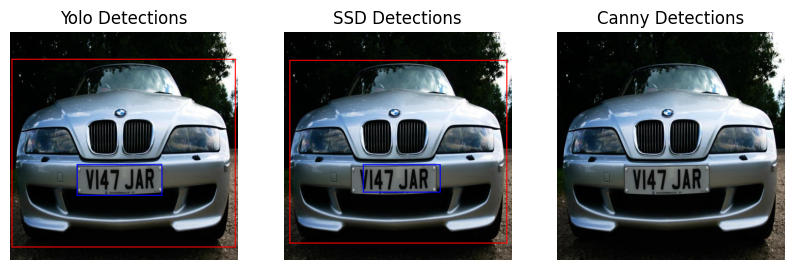


0: 640x640 2 Cars, 34.9ms
Speed: 15.3ms preprocess, 34.9ms inference, 22.2ms postprocess per image at shape (1, 3, 640, 640)


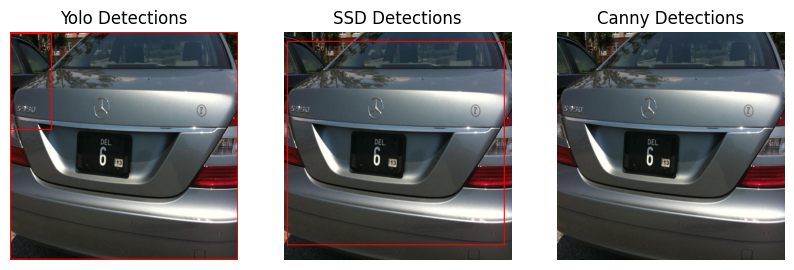


0: 640x640 1 Car, 1 Plate, 32.7ms
Speed: 2.7ms preprocess, 32.7ms inference, 24.3ms postprocess per image at shape (1, 3, 640, 640)


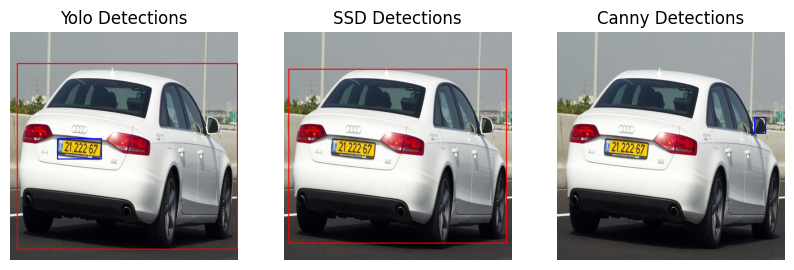


0: 640x640 3 Cars, 1 Plate, 12.5ms
Speed: 1.3ms preprocess, 12.5ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 640)


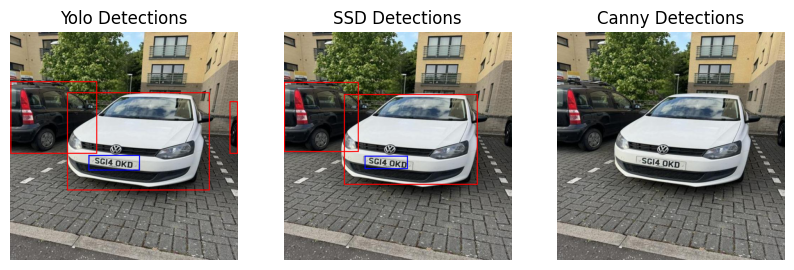


0: 640x640 4 Cars, 1 Plate, 8.8ms
Speed: 1.2ms preprocess, 8.8ms inference, 13.3ms postprocess per image at shape (1, 3, 640, 640)


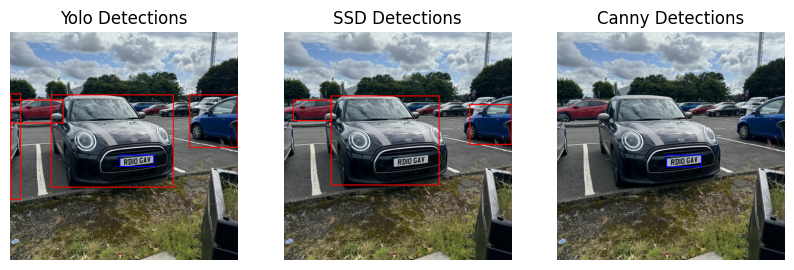


0: 640x640 4 Cars, 4 Plates, 10.3ms
Speed: 1.2ms preprocess, 10.3ms inference, 9.7ms postprocess per image at shape (1, 3, 640, 640)


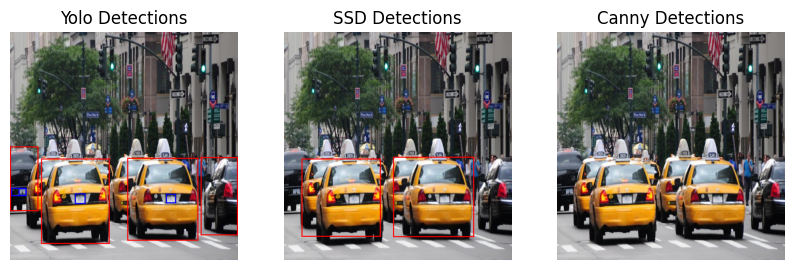


0: 640x640 2 Cars, 1 Plate, 8.2ms
Speed: 1.2ms preprocess, 8.2ms inference, 11.5ms postprocess per image at shape (1, 3, 640, 640)


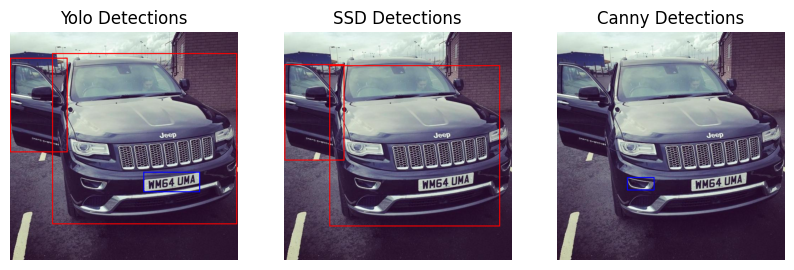


0: 640x640 7 Cars, 2 Plates, 13.4ms
Speed: 1.3ms preprocess, 13.4ms inference, 22.2ms postprocess per image at shape (1, 3, 640, 640)


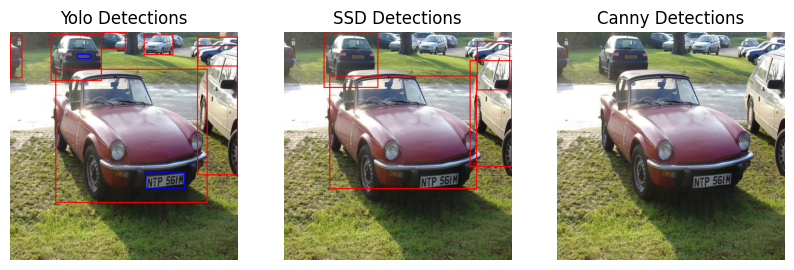


0: 640x640 1 Car, 1 Plate, 8.7ms
Speed: 1.2ms preprocess, 8.7ms inference, 13.4ms postprocess per image at shape (1, 3, 640, 640)


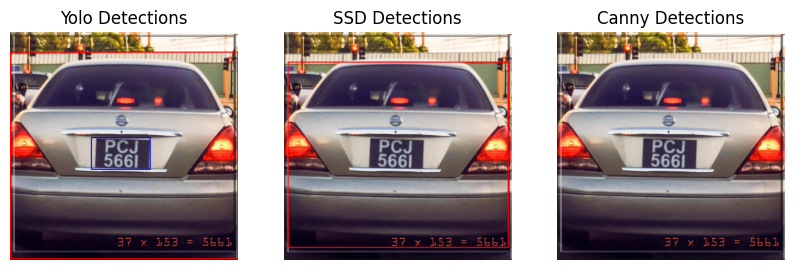


0: 640x640 2 Cars, 1 Plate, 8.5ms
Speed: 1.2ms preprocess, 8.5ms inference, 19.7ms postprocess per image at shape (1, 3, 640, 640)


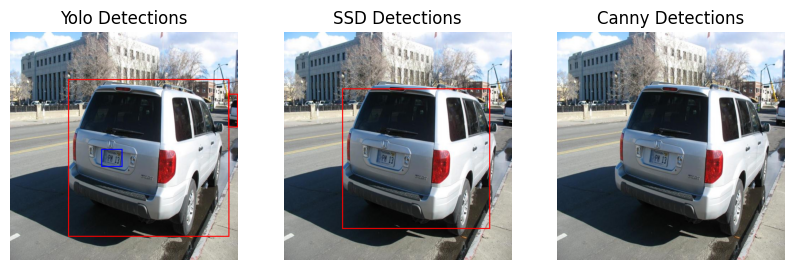

In [ ]:
np.random.seed(2)
test_sample = test_img_df.sample(10)

for row in test_sample.iterrows():
  file_path = row[1]['file_name']
  img = cv2.imread(file_path)
  org_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img = load_image(file_path)
  ssd_img = preprocess(img)
  with torch.no_grad():
    detections = yolo_model.predict(img)
    yolo_img = plot_detections(img, detections)
    canny_img = licenesPlatePipeline(org_img)

    test_dict = ssd_model(ssd_img)

    boxes = test_dict[0]['boxes']  # Example boxes
    scores = test_dict[0]['scores']  # Example scores
    classes = test_dict[0]['labels']  # Example classes  # Example class names
    refined_boxes = nms(boxes, scores, 0.4)
    ssd_img = plot_ssd_predictions(img
                                   , boxes[refined_boxes], scores[refined_boxes], classes[refined_boxes])

    plot_imgs(yolo_img, ssd_img, canny_img)
